In [106]:
# Import libraries

import numpy as np
from numpy.polynomial import Polynomial

from scipy.stats import norm, pearsonr
from scipy.signal import detrend
import scipy.fft as fft
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import local_functions as loc
import SeaLevelContrib as slc

In [107]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Define fixed data

In [108]:
# Set paths
data_atmosphere_dir = '/Users/sbult/Desktop/Scripts/data/data_atmosphere'
data_tidegauges_dir = '/Users/sbult/Desktop/Scripts/data'

# Method to constrain the BSpline smoothing. 
# The character is only used for figures.
# m1 for constrained by degrees of freedom
# m2 for constrained by penalisation weights
method = 'm2'

# Define window in years for rate computation, should be an even number
lag = 2

## Choose a region

In [440]:
region = 'North Shields'

if region == 'Vlissingen':
    tg_id = [20]
elif region == 'Hoek van Holland':
    tg_id = [22]
elif region == 'Den Helder':
    tg_id = [23]
elif region == 'Delfzijl':
    tg_id = [24]
elif region == 'Harlingen':
    tg_id = [25]
elif region == 'IJmuiden':
    tg_id = [32]
elif region == 'Brest':
    tg_id = [1]
elif region == 'Newlyn':
    tg_id = [202]
elif region == 'Stavanger':
    tg_id = [47]
elif region == 'Cuxhaven':
    tg_id = [7]
elif region == 'Cascais':
    tg_id = [52]
elif region == 'Esbjerg':
    tg_id = [80]
elif region == 'Bergen':
    tg_id = [58]
elif region == 'North Shields':
    tg_id = [95]
#elif region == 'Ketchikan':
#    tg_id = [225]
#elif region =='Pensacola':
#    tg_id = [246]

## Read tide gauge data and compute the average

In [441]:
def tide_gauge_obs(tg_id, interp=False):
    '''Read a list of tide gauge data and compute the average. 
    Set interp to True for a linear interpollation of missing values.
    By default use the 6 tide gauges from the Zeespiegelmonitor.
    The unit of the output is cm.''' 
    
    tg_data_dir = f'{data_tidegauges_dir}/tide gauges/rlr_annual'
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', 
                              header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')

    names_col2 = ('time', 'height', 'interpolated', 'flags')

    for i in range(len(tg_id)):
        tg_data = pd.read_csv(f'{tg_data_dir}/data/{tg_id[i]}.rlrdata', 
                              sep=';', header=None, names=names_col2)
        tg_data = tg_data.set_index('time')
        tg_data.height = tg_data.height.where(~np.isclose(tg_data.height,-99999))
        tg_data.height = tg_data.height - tg_data.height.mean()

        if i==0:
            tg_data_df = pd.DataFrame(data=dict(time=tg_data.index, 
                                                col_name=tg_data.height))
            tg_data_df = tg_data_df.set_index('time')
            tg_data_df.columns  = [str(tg_id[i])] 
        else:
            tg_data_df[str(tg_id[i])] = tg_data.height

    if interp:
        tg_data_df = tg_data_df.interpolate(method='slinear')
        
    tg_data_df['Average'] = tg_data_df.mean(axis=1)
    tg_data_df = tg_data_df * 0.1 # Convert from mm to cm
    
    return tg_data_df

In [442]:
tg_df = tide_gauge_obs(tg_id, interp=True)

if region in ['Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden','Brest','Newlyn','Stavanger','Cuxhaven','Esbjerg','Bergen','North Shields','Cascais']:
    tg_df = tg_df.loc[1890:] # Select years after 1890 as in the Zeespiegelmonitor
elif region == 'Tofino':
    tg_df = tg_df.loc[1945:]
    
nt = len(tg_df.index)    

tg_df

,95,Average
time,,
1896,-13.440909,-13.440909
1897,-5.540909,-5.540909
1898,-10.540909,-10.540909
1899,-10.540909,-10.540909
1900,-10.940909,-10.940909
...,...,...
2013,8.759091,8.759091
2014,11.459091,11.459091
2015,10.859091,10.859091


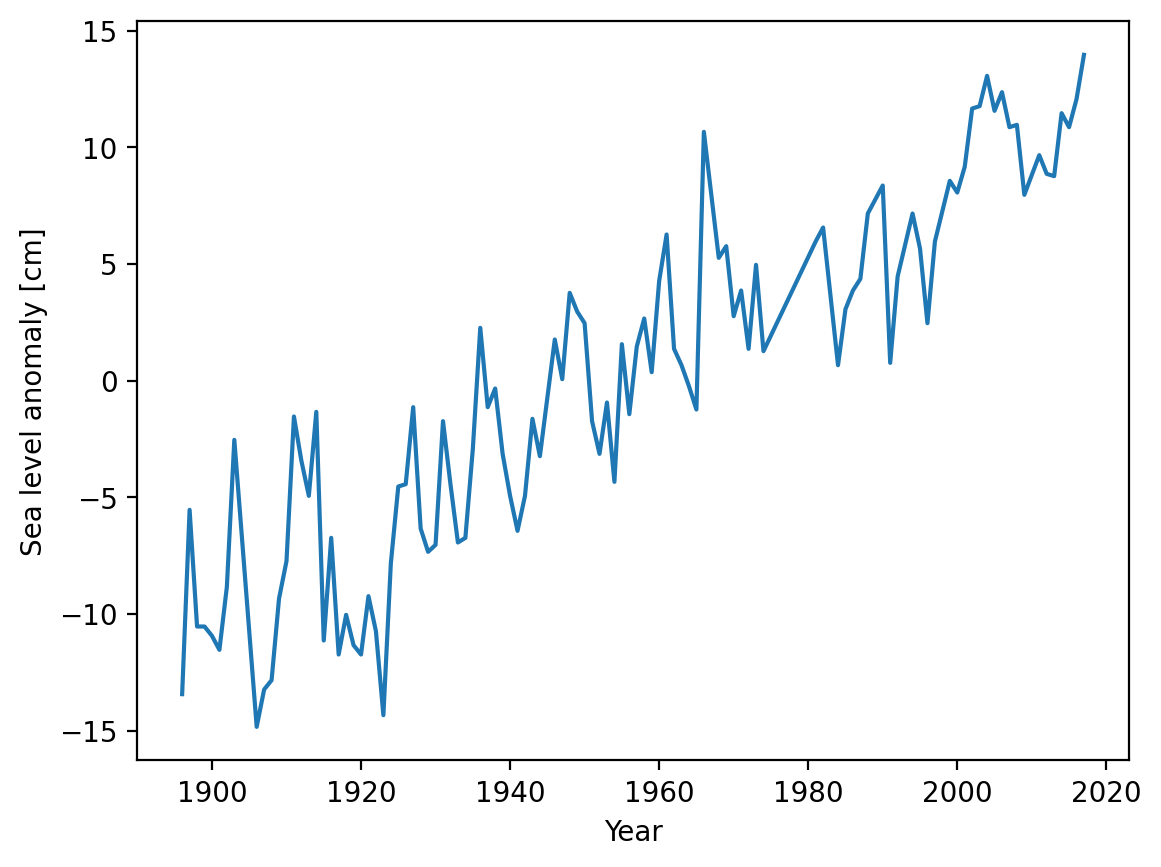

In [443]:
station = "{}".format(tg_id[0])

tg_df[station].plot()
plt.xlabel('Year')
plt.ylabel('Sea level anomaly [cm]');

In [444]:
def combine_linear_scaling(d20CR, dERA5, date_s, date_e):
    
    d20CR_cor = d20CR.copy()
    
    # Substract mean of 20CR over overlapping period
    d20CR_cor = d20CR - d20CR.loc[date_s:date_e].mean()
    
    # Scale using variance
    d20CR_cor = d20CR_cor*dERA5.loc[date_s:date_e].std()/d20CR_cor.loc[date_s:date_e].std()
    
    # Substract mean of ERA5 over overlapping period
    d20CR_cor = d20CR_cor + dERA5.loc[date_s:date_e].mean()
    
    combined_df = pd.concat([d20CR_cor.loc[:1939], dERA5.loc[1940:]])
    
    return combined_df

In [445]:
def read_wind_np(tgi):
    '''Read wind info for the two reanalysis files and combine them'''
    
    wind_info_20CR = pd.read_csv(f'{data_atmosphere_dir}/wind_data_20CR_tg{tgi}.csv')
    wind_info_20CR = wind_info_20CR.set_index('t')

    wind_info_ERA5 = pd.read_csv(f'{data_atmosphere_dir}/wind_data_ERA5_tg{tgi}.csv')
    wind_info_ERA5 = wind_info_ERA5.set_index('t')

    combined_df = combine_linear_scaling(wind_info_20CR[['u2','v2']], wind_info_ERA5[['u2','v2']], 1950, 2015)
    
    combined_df.index.rename('time', inplace=True)
    combined_df.rename(columns = {'u2' : f'u2_{tgi}', 'v2' : f'v2_{tgi}'}, inplace=True)
    
    return combined_df

In [446]:
for idx, tgi in enumerate(tg_id):
    
    if idx == 0:
        nearest_point_df = read_wind_np(tgi)
    else:
        nearest_point_df = nearest_point_df.join(read_wind_np(tgi), how='inner')
    
nearest_point_df['u2_mean'] = nearest_point_df.filter(regex='u2_').mean(axis=1)
nearest_point_df['v2_mean'] = nearest_point_df.filter(regex='v2_').mean(axis=1)

nearest_point_df

,u2_95,v2_95,u2_mean,v2_mean
time,,,,
1836,2.803386,-0.098549,2.803386,-0.098549
1837,2.357156,1.384971,2.357156,1.384971
1838,0.491322,0.218427,0.491322,0.218427
1839,1.751299,1.144939,1.751299,1.144939
1840,2.974826,-0.088373,2.974826,-0.088373
...,...,...,...,...
2018,3.084917,3.055194,3.084917,3.055194
2019,4.944241,2.978652,4.944241,2.978652
2020,6.789701,4.633930,6.789701,4.633930


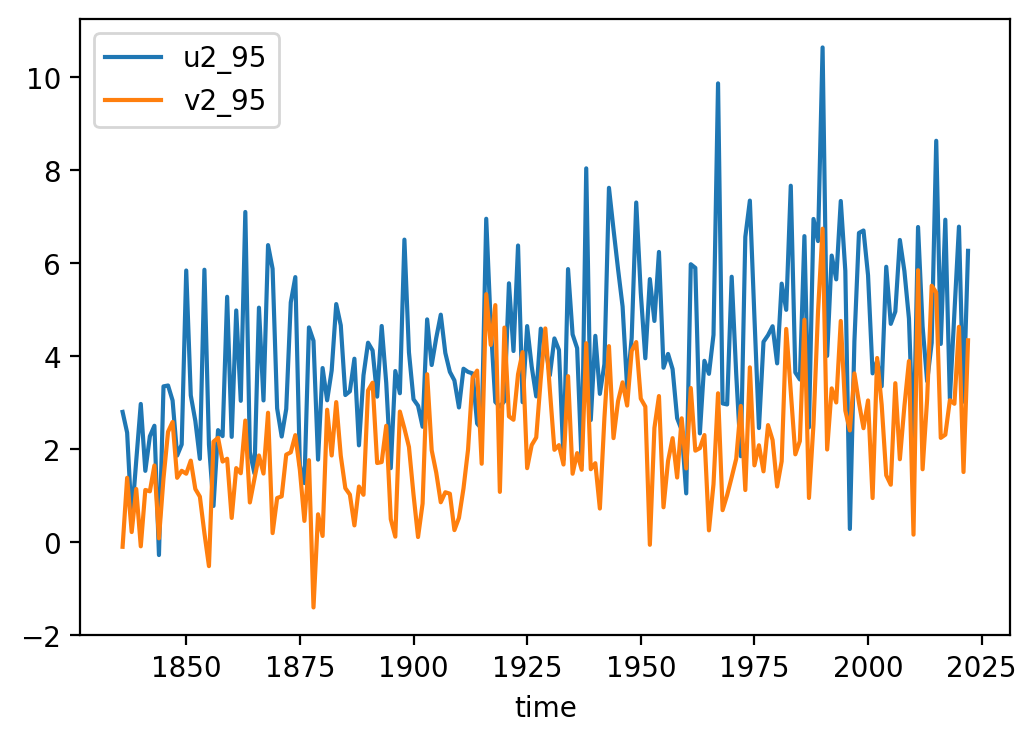

In [447]:
if len(tg_id) == 1:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    nearest_point_df[[f'u2_{tg_id[0]}',f'v2_{tg_id[0]}']].plot(ax=axes)
elif len(tg_id) == 3:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    
    for idx, tgi in enumerate(tg_id):
        nearest_point_df[[f'u2_{tgi}',f'v2_{tgi}']].plot(ax=axes[int(idx/3), idx%3])
        
elif len(tg_id) == 6:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

    for idx, tgi in enumerate(tg_id):
        nearest_point_df[[f'u2_{tgi}',f'v2_{tgi}']].plot(ax=axes[int(idx/3), idx%3])

#### Prepare a matrix of potential regressors

In [448]:
t = tg_df.index

reg_df = pd.DataFrame({'sea_level':tg_df['Average']})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

reg_df = reg_df.join(nearest_point_df, how='inner')
    
reg_df['one'] = np.ones(len(reg_df.index))

reg_df

,sea_level,nod1,nod2,u2_95,v2_95,u2_mean,v2_mean,one
time,,,,,,,,
1896,-13.440909,1.000000,0.000000,3.683210,0.119403,3.683210,0.119403,1.0
1897,-5.540909,0.943562,0.331195,3.205153,2.810495,3.205153,2.810495,1.0
1898,-10.540909,0.780620,0.625006,6.510575,2.448374,6.510575,2.448374,1.0
1899,-10.540909,0.529565,0.848270,4.084202,2.049337,4.084202,2.049337,1.0
1900,-10.940909,0.218735,0.975784,3.075480,1.025394,3.075480,1.025394,1.0
...,...,...,...,...,...,...,...,...
2013,8.759091,-0.223837,0.974627,3.463579,3.076386,3.463579,3.076386,1.0
2014,11.459091,-0.533996,0.845487,4.291325,5.519312,4.291325,5.519312,1.0
2015,10.859091,-0.783879,0.620913,8.637256,5.372840,8.637256,5.372840,1.0


#### Define the list of regressors and regression formula for the different models

In [449]:
# No regressor

reg_list_nr = []

regression_formula_nr = 'sea_level ~ '+' + '.join(reg_list_nr)

regression_formula_nr

'sea_level ~ '

In [450]:
# Only lunar nodal tide

reg_list_nt = ['nod1', 'nod2']

regression_formula_nt = 'sea_level ~ '+' + '.join(reg_list_nt)

regression_formula_nt

'sea_level ~ nod1 + nod2'

In [451]:
# Nearest point average, including zonal and meridional wind 'NearestPointAverage2'

reg_list_na_2 = ['nod1', 'nod2', 'u2_mean', 'v2_mean']


regression_formula_na_2 = 'sea_level ~ '+' + '.join(reg_list_na_2)
    
regression_formula_na_2

'sea_level ~ nod1 + nod2 + u2_mean + v2_mean'

In [452]:
def reg_list_formula(model):
    if model == 'NoRegressor':
        reg_list = reg_list_nr
        regression_formula = regression_formula_nr
    elif model == 'NodalTide':
        reg_list = reg_list_nt
        regression_formula = regression_formula_nt  
    elif model == 'NearestPointAverage':
        reg_list = reg_list_na
        regression_formula = regression_formula_na
    elif model == 'NearestPointAverage2':
        reg_list = reg_list_na_2
        regression_formula = regression_formula_na_2
    elif model == 'PressureDifference':
        reg_list = reg_list_pd
        regression_formula = regression_formula_pd
    elif model == 'PressureDifference2':
        reg_list = reg_list_pd_2
        regression_formula = regression_formula_pd_2
        
    return reg_list, regression_formula

## Define generalised additive model and store data

In [453]:
if method == 'm1':
    gam_df = 5
    gam_alpha = 0
elif method == 'm2':
    gam_df = nt//2
    gam_alpha = 5000

In [454]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

In [455]:
def store_results_df(reg_df, res_gam, reg_list, model):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['total_nodal'] = model_results_df['nod1'] + model_results_df['nod2']

    if model in ['NearestPointAverage', 'NearestPointAverage2']:
        model_results_df['total_wind'] = model_results_df.filter(regex='[u-v]2_').sum(axis=1)
    elif model == 'PressureDifference':
        model_results_df['total_wind'] = model_results_df.pressure_diff
    elif model == 'PressureDifference2':
        model_results_df['total_wind'] = model_results_df['pressure_north'] + model_results_df['pressure_south']
        
    return model_results_df

In [456]:
def compute_model(model, reg_df):
    
    reg_list, regression_formula = reg_list_formula(model)
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list, model)
    
    return model_results_df, res_gam

### Computations

In [457]:
res_nt, res_full_nt = compute_model('NodalTide', reg_df)

In [458]:
res_na_2, res_full_na_2 = compute_model('NearestPointAverage2', reg_df)

In [459]:
model_list = ['NodalTide','NearestPointAverage2']

In [466]:
import os

if not os.path.exists(f'/Users/sbult/Desktop/manuscript/data/output/tide_gauges/{region}'):
    os.makedirs(f'/Users/sbult/Desktop/manuscript/data/output/tide_gauges/{region}')

In [469]:
for idx, df in enumerate([res_nt,res_na_2]):
    df.to_csv(f'/Users/sbult/Desktop/manuscript/data/output/tide_gauges/{region}/results_{model_list[idx]}.csv')

In [461]:
summ = res_full_na_2.summary().tables[1].as_html()
summ1 = pd.read_html(summ, header=0, index_col=0)[0]

coef_nod1 = summ1['coef'].nod1
coef_nod2 = summ1['coef'].nod2
std_err_nod1 = summ1['std err'].nod1
std_err_nod2 = summ1['std err'].nod2

0.3626082911150783


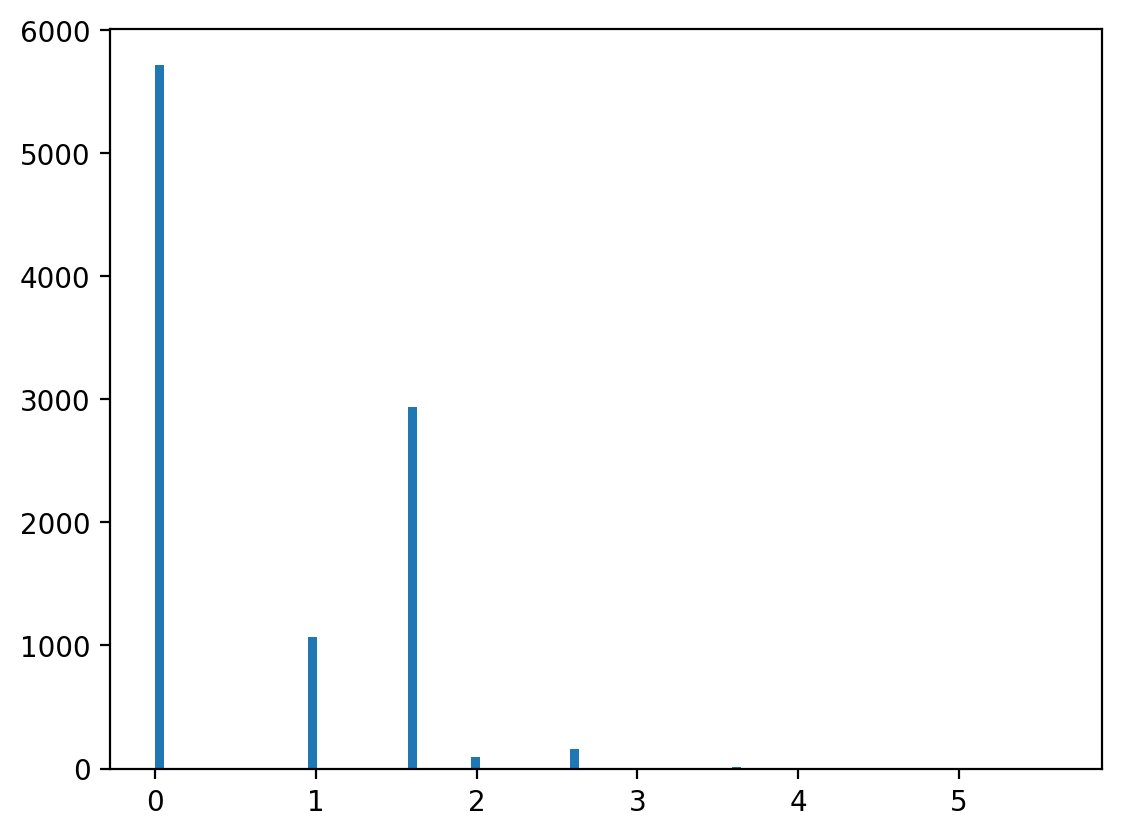

In [462]:
time = np.arange(1890,2020,1)
t0 = 1922.7

from scipy.stats import norm

mean = coef_nod1
std = std_err_nod1
mean2 = coef_nod2
std2 = std_err_nod2

omega = 2 * np.pi
t = (time-t0)/18.61

nod1 = np.random.normal(mean, std, 10000)
nod2 = np.random.normal(mean2, std2, 10000)

total_nodal = nod1[:,np.newaxis]*np.cos(omega*t) + nod2[:,np.newaxis]*np.sin(omega*t)

ampl = np.max(total_nodal,axis=1)
phase = np.zeros(10000)

for i in range(10000):
    if np.argmax(total_nodal[i,104:122]) > 9.3:
        phase[i] = 18.61 - np.argmax(total_nodal[i,104:122]) 
    else:
        phase[i] = np.argmax(total_nodal[i,104:122]) 
        
std_nod = np.std(ampl)
std_ph = np.std(phase)
print(std_nod)
plt.hist(phase,100);

In [463]:
regions = ['Cascais','Brest','Newlyn','Vlissingen','Hoek van Holland','IJmuiden','Den Helder','Harlingen','Delfzijl','Cuxhaven','Esbjerg','North Shields','Stavanger','Bergen']

# std = np.zeros((2,len(regions))) #only use the first time

std = np.loadtxt('/Users/sbult/Desktop/Scripts/data/tide gauges/standard_deviations.txt') #using in all other cases

for i in range(len(regions)):
    if region == regions[i]:
        std[0,i] = round(std_nod,3)
        std[1,i] = round(std_ph,3)
        
np.savetxt('/Users/sbult/Desktop/Scripts/data/tide gauges/standard_deviations.txt',std)

In [464]:
print(std)

[[0.304 0.313 0.295 0.284 0.277 0.342 0.273 0.268 0.299 0.304 0.404 0.363
  0.367 0.381]
 [0.951 1.359 0.79  0.611 0.834 0.695 0.632 0.798 0.704 1.395 0.804 0.793
  0.814 0.876]]


## Trend for tide gauge Delfzijl

Do not use for other tide gauges

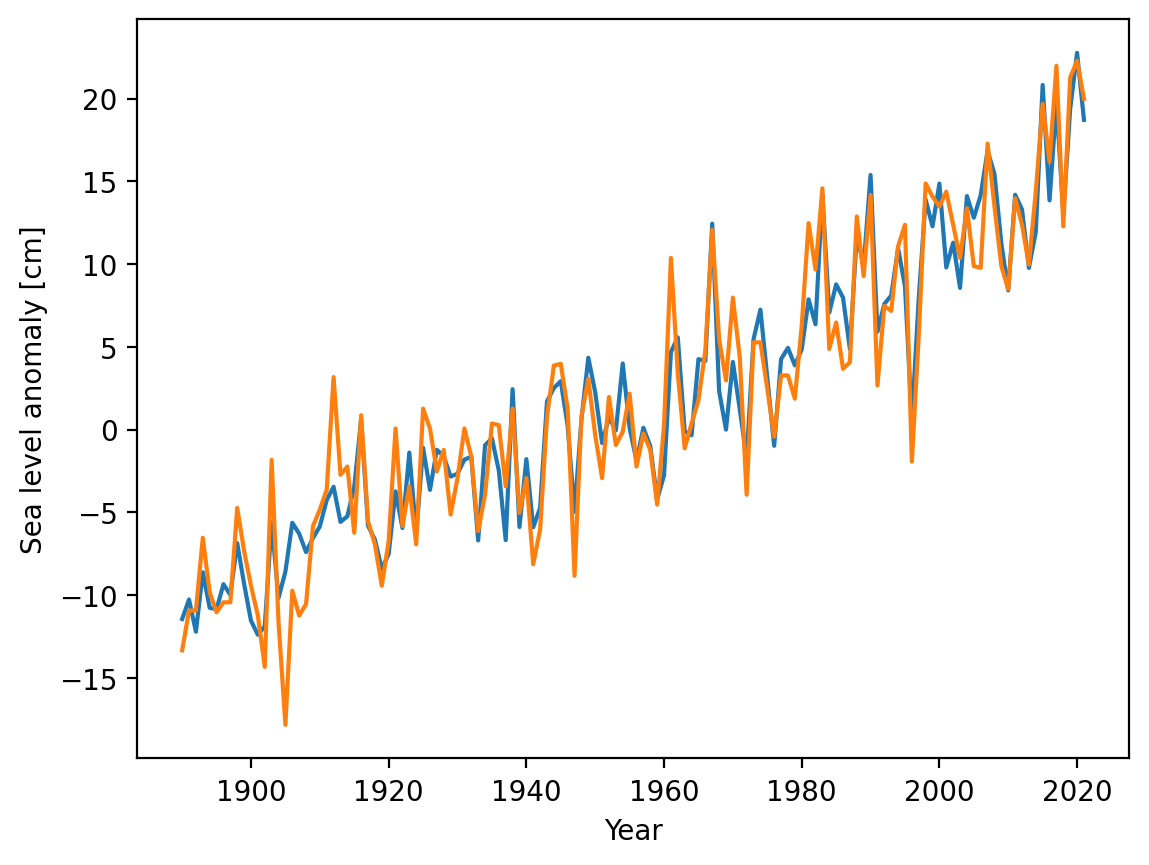

In [71]:
res_na_2['total'].plot();
tg_df['24'].plot()

modelfit = pd.DataFrame(index=time)
modelfit['model'] = res_na_2['total']
modelfit['tide gauge'] = tg_df['24']

#modelfit.to_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/delfzijl_npa2.csv')
plt.ylabel('Sea level anomaly [cm]');

plt.xlabel('Year');

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/tidegaugefit_Delfzijl.png', dpi=150)